### Back to Basics
Simply try all permutations. For each permutation, compute the optimal A by minimizing the log-likelihood using gradient descent. 

In [1]:
import sys
import itertools
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append("..")
import helper.helper as h

Generate a random $A$, with $\texttt{num_edges}$, where the edge weights are between $0.5$ and $1.0$. The matrix $A$ is lower triangular, but allows for entries to be non-zero on the diagonal.

In [2]:
def generate_A(n, num_edges):
    edges = np.array([0.0] * (int(n * (n + 1) / 2) - num_edges) + [1.0] * num_edges)
    
    edges[edges > 0] = (2 * np.random.randint(0, 2, size=(num_edges)) - 1) * np.random.uniform(0.5, 0.75, num_edges)
    np.random.shuffle(edges)
    
    A = np.zeros((n, n))
    A[np.tril_indices(n)] = edges
    
    return A

Generate data according to a VAR(1) model with $P^TAP$ as matrix. $\texttt{n}$-dimensional, $\texttt{s}$ non-zero entries, $\texttt{T}$ samples.

A:
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.  ]
 [-0.74  0.61  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.  ]
 [ 0.    0.   -0.51  0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.  ]
 [ 0.    0.    0.   -0.73  0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.  ]
 [-0.55  0.53  0.62  0.62  0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.  ]
 [-0.66  0.   -0.66  0.    0.71  0.52  0.    0.    0.    0.    0.    0.
   0.    0.    0.  ]
 [-0.73  0.    0.    0.56  0.    0.    0.68  0.    0.    0.    0.    0.
   0.    0.    0.  ]
 [-0.66  0.    0.    0.73  0.56  0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.  ]
 [ 0.   -0.67  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.  ]
 [ 0.    0.51  0.    0.    0.    0.   -0.66  0.    0.    0.    0.    0.
   0.    0.    0.  ]
 [ 0.61 -0.58  0.6   0.    0.   -0.67  0.    0.   -0.69  0.    0.  

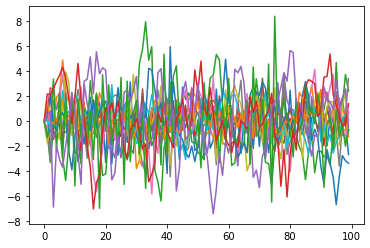

In [3]:
## Number of dimensions, number of edges, number of samples
T, n, s = 100, 15, 50

## Coefficient matrix
A_true = generate_A(n, s)

## True permutation
P_true = np.random.permutation(np.identity(n))

## Generate series
X = h.generate_var_2(T, n, A_true, P_true)
plt.plot(X);

print(f"A:\n{np.round(A_true, 2)}\n\nP:\n{P_true}.")

Loss function. Stack all data into $\mathbf{X}$.

The loss function is
$$l(A, P; \mathbf{X}) = \frac{1}{T-1}\left\lVert\mathbf{X}_{[1:T]} - \mathbf{X}_{[0:T-1]} P^T A P\right\rVert_F^2$$
Its gradient is
$$\nabla l(A, P; \mathbf{X}) = -\frac{2}{T-1}\left(\mathbf{X}_{[0:T-1]} P^T\right)^T \left\lVert\mathbf{X}_{[1:T]} - \mathbf{X}_{[0:T-1]} P^T A P\right\rVert_F P^T$$

In [4]:
def loss(A, P = np.identity(n)):
    W = P.T @ A @ P
    M = X @ W
    
    # Remove X[0] and XW[last]
    R = X[1:] - M[:-1]
    
    # Frobenius norm squared loss
    loss = 1 / X[1:].shape[0] * (R ** 2).sum()
    
    # Gradient using chain rule
    G_loss = - 2.0 / X[1:].shape[0] * (X[:-1] @ P.T).T @ R @ P.T
    
    return loss, G_loss

Optimizing $A$ given $P$. We use gradient descent, where we are only allowed to modify the lower triangular part of $A$ to adhere to acyclicity. 

We have
$$A \leftarrow A - \eta \cdot \nabla l(A, P; \mathbf{X})$$

In [5]:
def opt_A(P):
    # initialization
    A = np.zeros((n, n))
    
    # first loss evaluation
    l, g_A = loss(A, P)
    
    old_l = np.inf
    
    step_size = 5e-1
    
    # stopping criteration
    while np.sum(np.tril(np.abs(g_A))) > 1e-1:
        # gradient descent step
        A -= step_size * np.tril(g_A)

        # re-evaluate loss
        l, g_A = loss(A, P)
        
        # if we descended too far
        if l > old_l:
            step_size /= 1.5
        
        old_l = l
        
        step_size *= 1.1
    
    # return stationary point A
    return A

Likelihood of a permutation matrix $P$. In other words, the "score" we assign to a permutation matrix $P$. We define
$$l(P; \mathbf{X}) = \arg_{A \in LT} \min l(A, P; \mathbf{X})$$

In [6]:
def get_likelihood(P):
    # get optimal A for this permutation
    A_opt = opt_A(P)
    
    # get loss    
    return loss(A_opt, P)[0]

Naive algorithm. For each possible permutation matrix, compute all permutation matrices. In other words,
$$P = \arg_{P \in \mathcal{P}} \min l(P;\mathbf{X})$$

In [209]:
perms = itertools.permutations(np.identity(n))
total = np.math.factorial(n)

P_best, L_best = np.identity(n), get_likelihood(np.identity(n))

for perm in tqdm(perms, total=total):
    perm = np.array(perm)
    L = get_likelihood(perm)
    if L < L_best:
        P_best, L_best = perm, L

print(f"Exhaustively best P:\n{P_best},\n\nLikelihood: {round(L_best, 2)}.")

  0%|                                              | 113438/2432902008176640000 [13:12<4720546399746:12:58, 143.16it/s]


KeyboardInterrupt: 

### Verifications.
The permutation matrix $P$ should be compatible with $P_{true}$. In other words, there are no edges in $P_{true}$ that would "not be allowed" in $P$, because the we would have an arc pointing "back".

In [37]:
# verify whether the permutation is campatible
check = P_best @ P_true.T @ A_true @ P_true @ P_best.T
check_tril = np.tril(check)
print(len(check_tril[check_tril != 0]) == s)

False


Is the matrix $P^T A P$ equal or comparable to $P_{true}^T A_{true} P_{true}$? We check this. We also apply thresholding, note that cherrypicking this threshold should be avoided as it can give false hope, we do not know $W_{true}$.

In [38]:
thresh = 0.25
check_thresh = P_best.T @ opt_A(P_best) @ P_best
check_thresh[np.abs(check_thresh) < thresh] = 0
print(f"Thresholded W:\n{np.round(check_thresh, 2)}")

Thresholded W:
[[-0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.  ]
 [ 0.    0.55 -0.62  0.    0.    0.    0.    0.44  0.61  0.   -0.25  0.
   0.    0.56  0.  ]
 [ 0.    0.    0.62  0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.   -0.69]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.86  0.   -0.61]
 [ 0.58  0.   -0.46  0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.53]
 [ 0.    0.    0.   -0.36 -0.77 -0.31  0.    0.    0.    0.73  0.    0.
  -0.84  0.   -0.61]
 [ 0.54  0.    0.46  0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.74  0.   -0.58]
 [ 0.    0.   -0.65  0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.  ]
 [ 0.    0.    0.54  0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.  ]
 [ 0.    0.   -0.66  0.   -0.79  0.    0.    0.48  0.62  0.62  0.41  0.
   0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  

In [39]:
truth = P_true.T @ A_true @ P_true
print(f"True W:\n{np.round(truth, 2)}.")

True W:
[[-0.51  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.  ]
 [ 0.    0.59 -0.67  0.    0.    0.    0.    0.53  0.62  0.    0.    0.
   0.    0.53  0.  ]
 [ 0.    0.    0.61  0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.   -0.74]
 [ 0.    0.    0.    0.    0.    0.    0.56  0.    0.    0.    0.    0.
   0.73  0.   -0.66]
 [ 0.6   0.   -0.58  0.    0.    0.    0.   -0.69  0.    0.    0.    0.
   0.   -0.67  0.61]
 [ 0.    0.    0.   -0.51 -0.63 -0.55  0.    0.    0.    0.7   0.    0.
  -0.72  0.55 -0.61]
 [ 0.62  0.    0.53  0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.62  0.   -0.55]
 [ 0.    0.   -0.67  0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.  ]
 [ 0.    0.    0.51  0.    0.    0.    0.    0.    0.    0.   -0.66  0.
   0.    0.    0.  ]
 [ 0.    0.   -0.69  0.   -0.57  0.    0.    0.    0.55  0.66  0.65  0.
   0.   -0.64  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   

Statistics
- True Positive Rate (TPR): Percentage of edges in W_true that were in W
- True Negative Rate (TNR): Percentage of edges that were *not* in W_true that were also n*not* in W
- Accuracy: Percentage of correctly estimated entries of W
- False Detection Rate (FDR): Percentage of edges in W_est that were *not* in W_true

In [40]:
truth_bin = truth.copy()
truth_bin[truth_bin != 0] = 1

check_thresh_bin = check_thresh.copy()
check_thresh_bin[check_thresh_bin != 0] = 1

true_edges = np.flatnonzero(truth)
pred_edges = np.flatnonzero(check_thresh)
tpr = len(np.intersect1d(pred_edges, true_edges, assume_unique=True)) / len(true_edges)

true_non_edges = np.flatnonzero(truth_bin - 1)
pred_non_edges = np.flatnonzero(check_thresh_bin - 1)
tnr = len(np.intersect1d(pred_non_edges, true_non_edges, assume_unique=True)) / len(true_non_edges)

pred_false_edges = np.setdiff1d(pred_edges, true_edges)
fpr = len(pred_false_edges) / len(pred_edges)

accuracy = len(truth_bin[truth_bin == check_thresh_bin]) / len(truth_bin.flatten())
print(f"True Positive Rate: {round(tpr, 3)}.\nTrue Negative Rate: {round(tnr, 3)}.\nFalse Prediction Rate: {round(fpr, 3)}\nAccuracy: {round(accuracy, 3)}.")

True Positive Rate: 0.88.
True Negative Rate: 0.989.
False Prediction Rate: 0.043
Accuracy: 0.964.


In [14]:
check_thresh[check_thresh != 0] = 1
truth[truth != 0] = 1
truth[truth != check_thresh] = "-1"
truth[truth == check_thresh] = "1"

print(f"Entry is 1 if correct, -1 if false:\n{truth}.")
print(f"{np.sum(truth[truth == 1])}.")

Entry is 1 if correct, -1 if false:
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.]
 [ 1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]].
216.0.


## Conclusions
- By definition exactly optimal. We solve the problem exactly, and (apart from not solving the gradient to a stationary point), we get exactly the optimal solution.
- Takes too long! Even for ten nodes, we take too much time (also because finding A has not been optimized (by a long shot!), but the point still stands.
    - Perhaps we can not try ``all", but a random set of e.g. $n^2$ permutations.

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.30it/s]

Best P from 1000 different Ps:
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]],

Likelihood: 16.44.


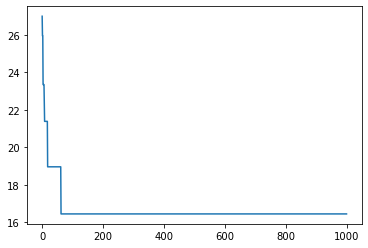

In [41]:
I = np.identity(n)
max_it = 1000
P_best, L_best = I, get_likelihood(I)

# results
results_likelihood = [L_best]
results_iteration = [0]
    
for i in tqdm(range(max_it)):
    perm = np.random.permutation(I)
    L = get_likelihood(perm)
    if L < L_best:
        P_best, L_best = perm, L
        
    results_likelihood.append(L_best)
    results_iteration.append(i + 1)

print(f"Best P from {max_it} different Ps:\n{P_best},\n\nLikelihood: {round(L_best, 2)}.")
plt.plot(results_iteration, results_likelihood)

In [42]:
print(get_likelihood(P_true))

13.15310389393012
